# Lending club case study

## Team:
*   Keshav Sharma
*   Ashish Nair


#### Goal: Identify important features in data that contribute towards loan default.

#### Import CSV and inspect data

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv("~/Downloads/csvs/loan.csv")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
raw_data.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [7]:
raw_data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

> ### Review each column in data dictionary and shortlist features to analyze, pick columns which are likely to be available in loan application

#### Shortlisted columns

* loan_status
* loan_amnt
* purpose
* term
* int_rate
* grade
* sub_grade
* issue_d
* emp_length
* dti
* annual_inc
* home_ownership
* verification_status
* application_type
* addr_state
* zip_code

#### Extract shorlisted column from dataframe

In [354]:
loan_data=raw_data[['loan_amnt', 'loan_status', 'purpose', 'term', 'int_rate', 'grade', 'sub_grade', 'issue_d', 'emp_length', 'dti', 'annual_inc', 'home_ownership', 'verification_status', 'application_type', 'addr_state', 'zip_code']]

## Basic inspection and univariate analysis using `pandas_profiling` library

In [ ]:
profile = ProfileReport(loan_data, title="Pandas Profiling Report", explorative=True)

In [356]:
profile

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Findings from profiling report:
* **application_type**: constant, so drop it
* **int_rate**: convert string to numerical, remove '%' symbol
* **grade**: check correlation with sub_grade
* **issue_d**: extract month from date
* **emp_length**: missing values need to be addressed
* **dti**: binning required
* **annual_inc**: address outliers, binning
* **loan_amnt**: binning
* **int_rate**: binning

# Data cleaning

### **application_type**: constant, so drop it

In [357]:
loan_data.application_type.unique()

array(['INDIVIDUAL'], dtype=object)

In [ ]:
loan_data.drop('application_type', axis=1, inplace=True)

### **loan_status**: drop rows with 'current' loan status as we cant decide whether they ll default or not

In [359]:
loan_data = loan_data[loan_data.loan_status != 'Current']

In [360]:
loan_data.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

#### Convert target variable loan_status to binary for better analysis

In [ ]:
loan_data['loan_status'] = loan_data.loan_status.astype('category')

In [362]:
loan_data.loan_status.head(5)

0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
5     Fully Paid
Name: loan_status, dtype: category
Categories (2, object): ['Charged Off', 'Fully Paid']

In [ ]:
loan_data['loan_status'] = loan_data.loan_status.cat.codes

In [364]:
loan_data.loan_status.head(5)

0    1
1    0
2    1
3    1
5    1
Name: loan_status, dtype: int8

In [ ]:
loan_data['loan_status'] = loan_data.loan_status.replace({0:1, 1:0})

In [366]:
loan_data.loan_status.head(5)

0    0
1    1
2    0
3    0
5    0
Name: loan_status, dtype: int64

### **int_rate**: convert string to numerical, remove '%' symbol

In [367]:
loan_data.int_rate

0        10.65%
1        15.27%
2        15.96%
3        13.49%
5         7.90%
          ...  
39712     8.07%
39713    10.28%
39714     8.07%
39715     7.43%
39716    13.75%
Name: int_rate, Length: 38577, dtype: object

In [368]:
loan_data.int_rate.str.replace('%','').astype(float)

0        10.65
1        15.27
2        15.96
3        13.49
5         7.90
         ...  
39712     8.07
39713    10.28
39714     8.07
39715     7.43
39716    13.75
Name: int_rate, Length: 38577, dtype: float64

In [ ]:
loan_data['int_rate']=loan_data.int_rate.str.replace('%','').astype(float)

### **grade**: check correlation with sub_grade, and drop if required

In [370]:
pd.pivot_table(loan_data, index=['grade'],values=['loan_status'])

,loan_status
grade,
A,0.059930
B,0.122056
C,0.171943
D,0.219862
E,0.268494
F,0.326844
G,0.337793


In [371]:
pd.pivot_table(loan_data, index=['grade', 'sub_grade'],values=['loan_status'])

loan_status
grade sub_grade             
A     A1            0.026339
      A2            0.049072
      A3            0.056906
      A4            0.061956
      A5            0.079926
B     B1            0.095159
      B2            0.113943
      B3            0.120708
      B4            0.135002
      B5            0.136138
C     C1            0.163504
      C2            0.166235
      C3            0.181452
      C4            0.175788
      C5            0.180243
D     D1            0.179377
      D2            0.210731
      D3            0.229391
      D4            0.234205
      D5            0.250600
E     E1            0.274238
      E2            0.265472
      E3            0.230620
      E4            0.297170
      E5            0.281654
F     F1            0.298361
      F2            0.300429
      F3            0.293103
      F4            0.350993
      F5            0.477876
G     G1            0.329787
      G2            0.363636
      G3            0.422222
      G4            0.240741
      G5            0.344828

> #### Some subgrades have high default rate

### **issue_d**: extract month from date

In [372]:
loan_data.issue_d.head(5)

0    Dec-11
1    Dec-11
2    Dec-11
3    Dec-11
5    Dec-11
Name: issue_d, dtype: object

In [373]:
loan_data.issue_d.str.split('-')

0        [Dec, 11]
1        [Dec, 11]
2        [Dec, 11]
3        [Dec, 11]
5        [Dec, 11]
           ...    
39712    [Jul, 07]
39713    [Jul, 07]
39714    [Jul, 07]
39715    [Jul, 07]
39716    [Jun, 07]
Name: issue_d, Length: 38577, dtype: object

In [ ]:
loan_data['issue_month']=loan_data.issue_d.str.split('-').str[0]

In [375]:
loan_data.issue_month.tail(5)

39712    Jul
39713    Jul
39714    Jul
39715    Jul
39716    Jun
Name: issue_month, dtype: object

##### Drop issue_d

In [ ]:
loan_data.drop('issue_d', axis=1, inplace=True)

#### **emp_length**: missing values need to be addressed

In [377]:
loan_data.emp_length.unique()

array(['10+ years', '< 1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '1 year', '6 years', '2 years', '7 years',
       nan], dtype=object)

In [378]:
loan_data.emp_length.isna().sum()

1033

In [379]:
loan_data.emp_length.describe()

count         37544
unique           11
top       10+ years
freq           8488
Name: emp_length, dtype: object

> _Lets check if employment length can be considered relative to annual income so that we can use it to impude missing employment length_ 

In [380]:
# create a temp dataframe, removing annual income outliers
ld_temp = loan_data[loan_data.annual_inc < loan_data.annual_inc.quantile(0.75)]

# remove 10+ years emp length as its actual value can be quite higher
ld_temp = ld_temp[ld_temp.emp_length != '10+ years']

# extract digit from emp_length
ld_temp['emp_length'] = ld_temp.emp_length.str.extract('(\d+)')

# convert to float to check correlation
ld_temp['emp_length'] = ld_temp['emp_length'].astype(float)

# check correlation
ld_temp.emp_length.corr(ld_temp.annual_inc)

0.14257273138111723

> _We found out that employment length and annual income are **not** correlated in this data, lets fill values as 'unknown'_ 

In [ ]:
loan_data['emp_length'] = loan_data['emp_length'].fillna('Unknown')

### **dti**: bin dti for easier plotting

In [384]:
loan_data.dti.describe()

count    38577.000000
mean        13.272727
std          6.673044
min          0.000000
25%          8.130000
50%         13.370000
75%         18.560000
max         29.990000
Name: dti, dtype: float64

In [385]:
pd.cut(loan_data.dti,6).value_counts()

(9.997, 14.995]     9624
(14.995, 19.993]    8824
(4.998, 9.997]      7861
(19.993, 24.992]    6599
(-0.03, 4.998]      5044
(24.992, 29.99]      625
Name: dti, dtype: int64

In [ ]:
loan_data['dti_bin'] = pd.cut(loan_data.dti,6)

### **annual_inc**: address outliers, binning

In [387]:
loan_data.annual_inc.describe()

count    3.857700e+04
mean     6.877797e+04
std      6.421868e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.886800e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

<AxesSubplot:>

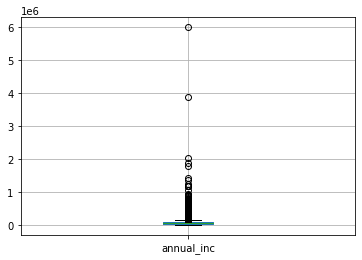

In [388]:
loan_data.boxplot(column=['annual_inc'])

<AxesSubplot:>

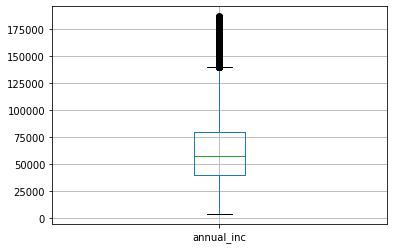

In [389]:
loan_data[loan_data.annual_inc < loan_data.annual_inc.quantile(.98)].boxplot(column=['annual_inc'])

> #### _using quantile based cut will be better for this data as the distribution is skewed_

In [390]:
pd.qcut(loan_data.annual_inc,8).value_counts()

(40000.0, 50000.0]       5691
(58868.0, 69000.0]       4894
(3999.999, 31200.0]      4873
(31200.0, 40000.0]       4825
(106000.0, 6000000.0]    4813
(69000.0, 82000.0]       4806
(82000.0, 106000.0]      4775
(50000.0, 58868.0]       3900
Name: annual_inc, dtype: int64

In [ ]:
loan_data['annual_inc_bin'] = pd.qcut(loan_data.annual_inc,8)

### **loan_amnt**: bin loan_amnt for easier plotting

In [392]:
loan_data.loan_amnt.describe()

count    38577.000000
mean     11047.025430
std       7348.441646
min        500.000000
25%       5300.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

In [393]:
pd.cut(loan_data.loan_amnt,6).value_counts()

(6250.0, 12000.0]     13279
(465.5, 6250.0]       12479
(12000.0, 17750.0]     5903
(17750.0, 23500.0]     3503
(23500.0, 29250.0]     2317
(29250.0, 35000.0]     1096
Name: loan_amnt, dtype: int64

In [ ]:
loan_data['loan_amnt_bin'] = pd.cut(loan_data.loan_amnt,6)

### **int_rate**: bin int_rate for easier plotting

In [395]:
loan_data.int_rate.describe()

count    38577.000000
mean        11.932219
std          3.691327
min          5.420000
25%          8.940000
50%         11.710000
75%         14.380000
max         24.400000
Name: int_rate, dtype: float64

In [396]:
pd.cut(loan_data.int_rate,6).value_counts()

(11.747, 14.91]     10864
(8.583, 11.747]     10589
(5.401, 8.583]       8737
(14.91, 18.073]      6153
(18.073, 21.237]     1908
(21.237, 24.4]        326
Name: int_rate, dtype: int64

In [ ]:
loan_data['int_rate_bin'] = pd.cut(loan_data.int_rate,6)

# Data Analysis

### We need to find correlation between these variables and loan_status to check if we find a pattern

In [398]:
# review the dataframe
loan_data

,loan_amnt,loan_status,purpose,term,int_rate,grade,sub_grade,emp_length,dti,annual_inc,home_ownership,verification_status,addr_state,zip_code,issue_month,dti_bin,annual_inc_bin,loan_amnt_bin,int_rate_bin
0,5000,0,credit_card,36 months,10.65,B,B2,10+ years,27.65,24000.0,RENT,Verified,AZ,860xx,Dec,"(24.992, 29.99]","(3999.999, 31200.0]","(465.5, 6250.0]","(8.583, 11.747]"
1,2500,1,car,60 months,15.27,C,C4,< 1 year,1.00,30000.0,RENT,Source Verified,GA,309xx,Dec,"(-0.03, 4.998]","(3999.999, 31200.0]","(465.5, 6250.0]","(14.91, 18.073]"
2,2400,0,small_business,36 months,15.96,C,C5,10+ years,8.72,12252.0,RENT,Not Verified,IL,606xx,Dec,"(4.998, 9.997]","(3999.999, 31200.0]","(465.5, 6250.0]","(14.91, 18.073]"
3,10000,0,other,36 months,13.49,C,C1,10+ years,20.00,49200.0,RENT,Source Verified,CA,917xx,Dec,"(19.993, 24.992]","(40000.0, 50000.0]","(6250.0, 12000.0]","(11.747, 14.91]"
5,5000,0,wedding,36 months,7.90,A,A4,3 years,11.20,36000.0,RENT,Source Verified,AZ,852xx,Dec,"(9.997, 14.995]","(31200.0, 40000.0]","(465.5, 6250.0]","(5.401, 8.583]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,2500,0,home_improvement,36 months,8.07,A,A4,4 years,11.33,110000.0,MORTGAGE,Not Verified,CO,802xx,Jul,"(9.997, 14.995]","(106000.0, 6000000.0]","(465.5, 6250.0]","(5.401, 8.583]"
39713,8500,0,credit_card,36 months,10.28,C,C1,3 years,6.40,18000.0,RENT,Not Verified,NC,274xx,Jul,"(4.998, 9.997]","(3999.999, 31200.0]","(6250.0, 12000.0]","(8.583, 11.747]"
39714,5000,0,debt_consolidation,36 months,8.07,A,A4,< 1 year,2.30,100000.0,MORTGAGE,Not Verified,MA,017xx,Jul,"(-0.03, 4.998]","(82000.0, 106000.0]","(465.5, 6250.0]","(5.401, 8.583]"
39715,5000,0,other,36 months,7.43,A,A2,< 1 year,3.72,200000.0,MORTGAGE,Not Verified,MD,208xx,Jul,"(-0.03, 4.998]","(106000.0, 6000000.0]","(465.5, 6250.0]","(5.401, 8.583]"


#### Check overall distribution of "fully paid" and "default loans"

<AxesSubplot:ylabel='loan_status'>

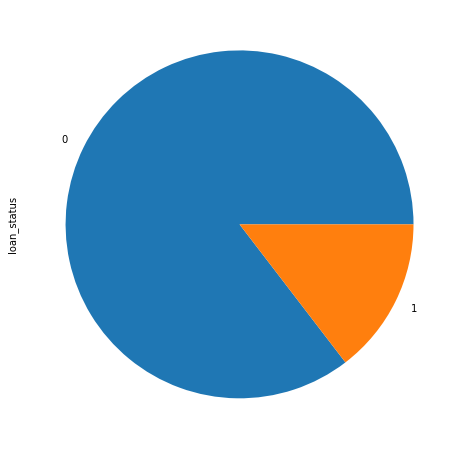

In [529]:
loan_data['loan_status'].value_counts(1).plot(kind='pie', figsize=(8,8))

---
### Check the distribution of loan status against **loan amount**

<AxesSubplot:xlabel='loan_amnt_bin'>

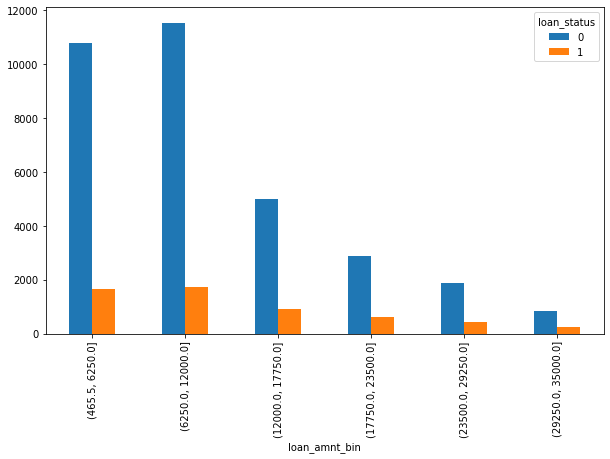

In [400]:
loan_data.groupby('loan_amnt_bin')['loan_status'].value_counts().unstack().plot(kind='bar', figsize=(10,6))

In [401]:
pd.pivot_table(loan_data, index=['loan_amnt_bin'],values=['loan_status'])

,loan_status
loan_amnt_bin,
"(465.5, 6250.0]",0.133905
"(6250.0, 12000.0]",0.131335
"(12000.0, 17750.0]",0.153481
"(17750.0, 23500.0]",0.176991
"(23500.0, 29250.0]",0.186880
"(29250.0, 35000.0]",0.230839


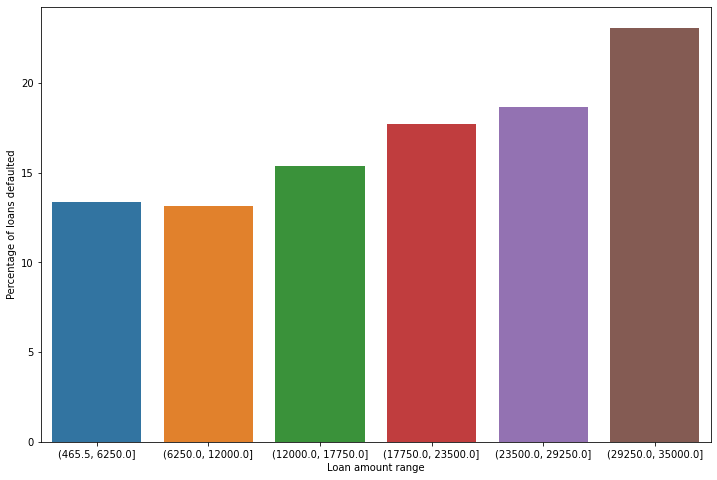

In [454]:
plot_data = loan_data.groupby('loan_amnt_bin')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(12,8))
sns.barplot(x='loan_amnt_bin', y='loan_status', data=plot_data)
plt.xlabel('Loan amount range')
plt.ylabel('Percentage of loans defaulted')
plt.show()

> ## Loan amounts between 30-35k are more likely to default that other ranges

---
### Check the distribution of loan status against **purpose**

<AxesSubplot:xlabel='purpose'>

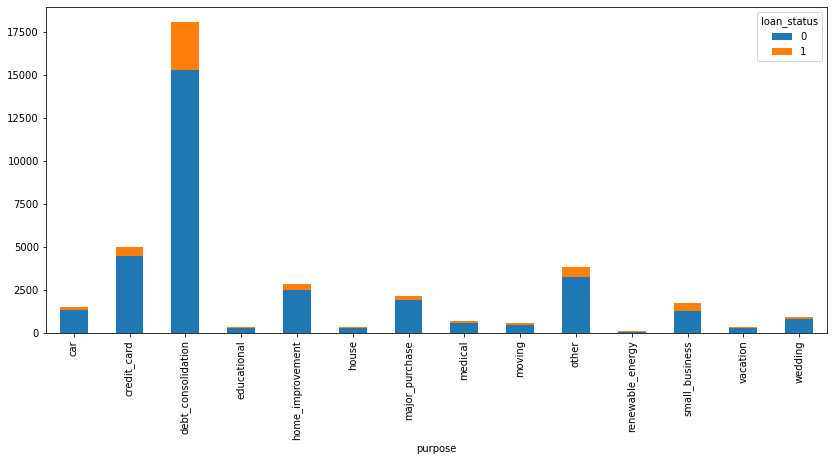

In [403]:
loan_data.groupby('purpose')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(14,6))

In [404]:
pd.pivot_table(loan_data, index=['purpose'],values=['loan_status'])

,loan_status
purpose,
car,0.106738
credit_card,0.107818
debt_consolidation,0.153254
educational,0.172308
home_improvement,0.120696
house,0.160763
major_purchase,0.103256
medical,0.155653
moving,0.159722


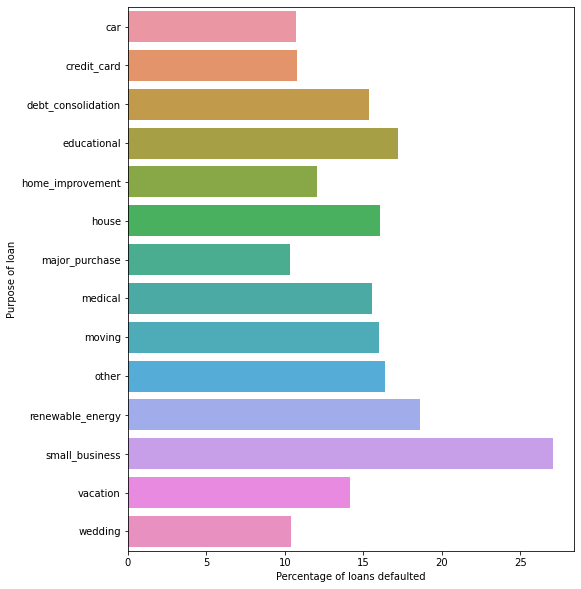

In [463]:
plot_data = loan_data.groupby('purpose')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(8,10))
sns.barplot(y='purpose', x='loan_status', data=plot_data)
plt.ylabel('Purpose of loan')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Loans for "Small business" are likely to default that other purposes

---
### Check the distribution of loan status against **term**

<AxesSubplot:xlabel='term'>

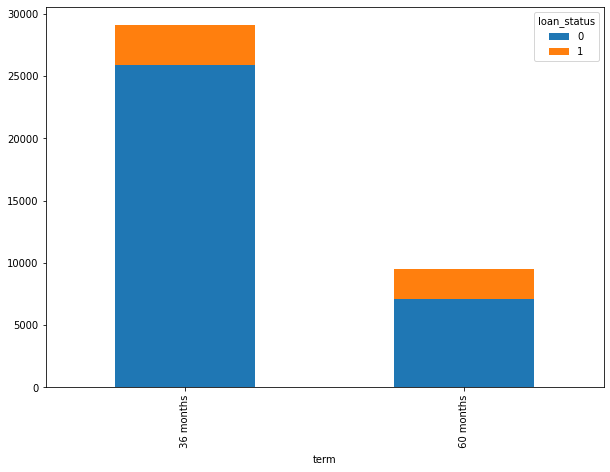

In [406]:
loan_data.groupby('term')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10,7))

In [407]:
pd.pivot_table(loan_data, index=['term'],values=['loan_status'])

,loan_status
term,
36 months,0.110909
60 months,0.253138


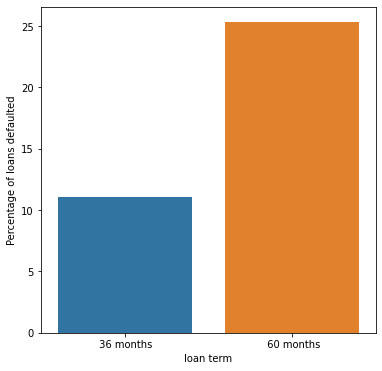

In [465]:
plot_data = loan_data.groupby('term')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(6,6))
sns.barplot(x='term', y='loan_status', data=plot_data)
plt.xlabel('loan term')
plt.ylabel('Percentage of loans defaulted')
plt.show()

> ## Long term loans (60 months) default more than short term (36 months)

---
### Check the distribution of loan status against **interest rate**

<AxesSubplot:xlabel='int_rate_bin'>

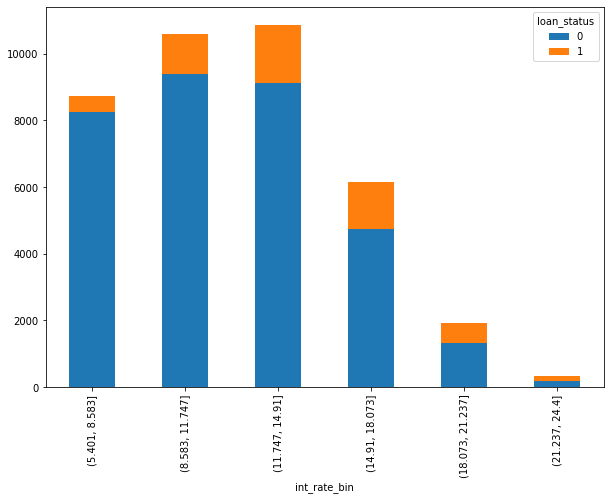

In [435]:
loan_data.groupby('int_rate_bin')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10,7))

In [436]:
pd.pivot_table(loan_data, index=['int_rate_bin'],values=['loan_status'])

,loan_status
int_rate_bin,
"(5.401, 8.583]",0.056541
"(8.583, 11.747]",0.114742
"(11.747, 14.91]",0.161911
"(14.91, 18.073]",0.231432
"(18.073, 21.237]",0.309748
"(21.237, 24.4]",0.441718


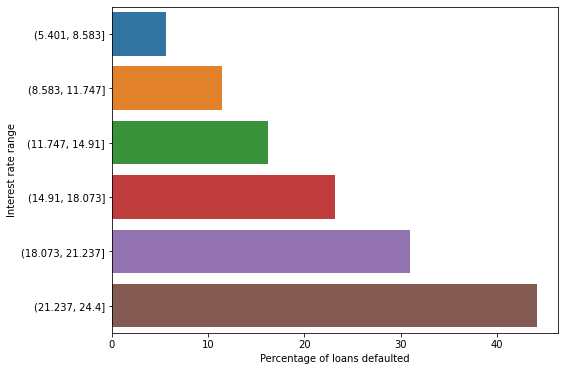

In [470]:
plot_data = loan_data.groupby('int_rate_bin')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(8,6))
sns.barplot(y='int_rate_bin', x='loan_status', data=plot_data)
plt.ylabel('Interest rate range')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Rate of default increases with interest rate, loan with interest rate above 20 have very high chances of default

---
### Check the distribution of loan status against **grade and subgrade**

<AxesSubplot:xlabel='grade,sub_grade'>

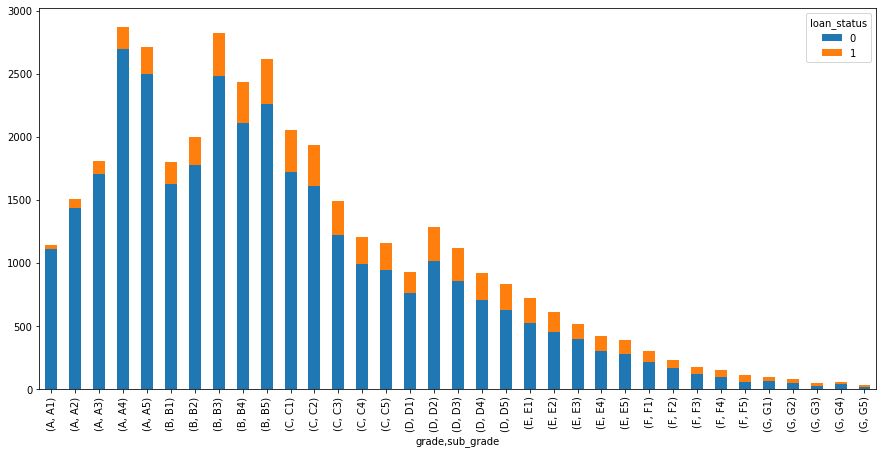

In [412]:
loan_data.groupby(['grade', 'sub_grade'])['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15,7))

In [413]:
pd.pivot_table(loan_data, index=['grade', 'sub_grade'],values=['loan_status'])

loan_status
grade sub_grade             
A     A1            0.026339
      A2            0.049072
      A3            0.056906
      A4            0.061956
      A5            0.079926
B     B1            0.095159
      B2            0.113943
      B3            0.120708
      B4            0.135002
      B5            0.136138
C     C1            0.163504
      C2            0.166235
      C3            0.181452
      C4            0.175788
      C5            0.180243
D     D1            0.179377
      D2            0.210731
      D3            0.229391
      D4            0.234205
      D5            0.250600
E     E1            0.274238
      E2            0.265472
      E3            0.230620
      E4            0.297170
      E5            0.281654
F     F1            0.298361
      F2            0.300429
      F3            0.293103
      F4            0.350993
      F5            0.477876
G     G1            0.329787
      G2            0.363636
      G3            0.422222
      G4            0.240741
      G5            0.344828

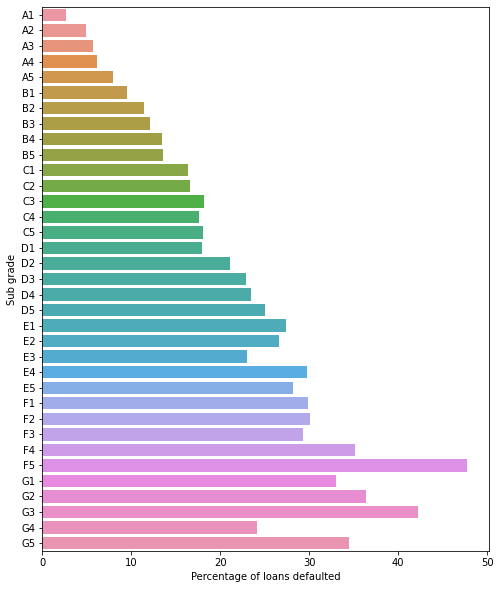

In [475]:
plot_data = loan_data.groupby(['grade', 'sub_grade'])['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(8,10))
sns.barplot(y='sub_grade', x='loan_status', data=plot_data)
plt.ylabel('Sub grade')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Default rate increases almost linearly as grade and sub_grade falls but certain grades like F5 and G3 have highest default rate

---
### Check the distribution of loan status against **employment length**

<AxesSubplot:xlabel='emp_length'>

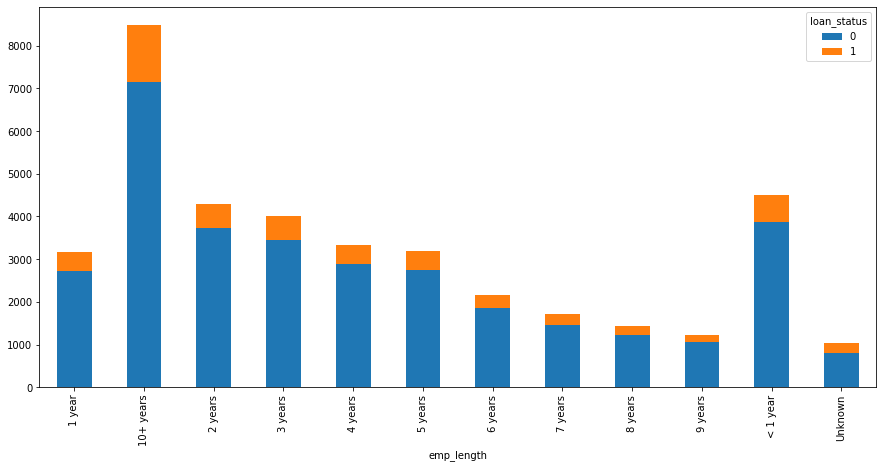

In [415]:
loan_data.groupby('emp_length')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15,7))

In [416]:
pd.pivot_table(loan_data, index=['emp_length'],values=['loan_status'])

,loan_status
emp_length,
1 year,0.143894
10+ years,0.156810
2 years,0.132137
3 years,0.138335
4 years,0.138241
5 years,0.143394
6 years,0.141605
7 years,0.153711
8 years,0.141463


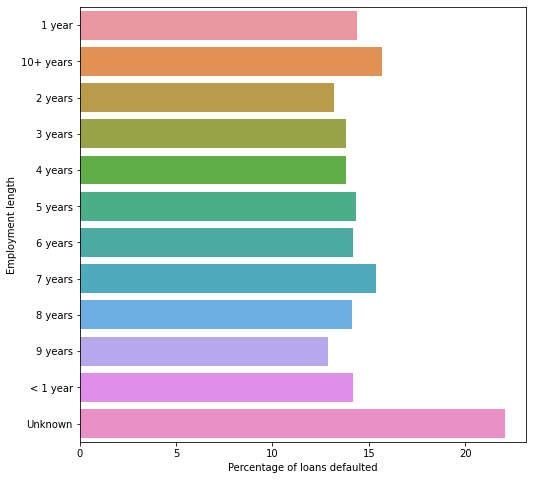

In [477]:
plot_data = loan_data.groupby('emp_length')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(8,8))
sns.barplot(y='emp_length', x='loan_status', data=plot_data)
plt.ylabel('Employment length')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Default rate is mostly independent of employment length but default rate is significatly higher when employment length is "unknown", so if lender doesn't provide employment length in records, it can be considered a risky loan

---
### Check the distribution of loan status against **debt to income ratio**

<AxesSubplot:xlabel='dti_bin'>

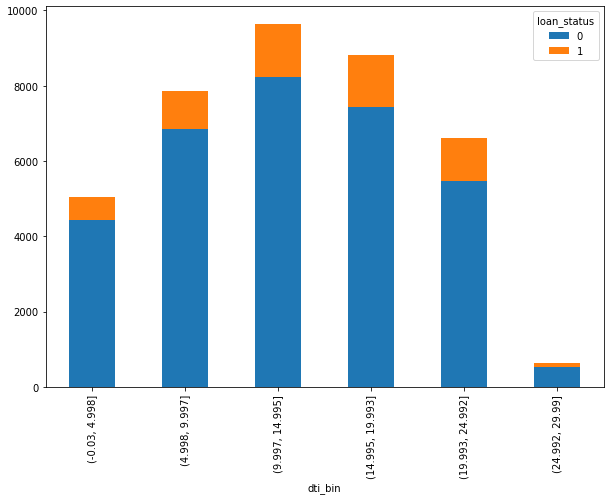

In [418]:
loan_data.groupby('dti_bin')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10,7))

In [419]:
pd.pivot_table(loan_data, index=['dti_bin'],values=['loan_status'])

,loan_status
dti_bin,
"(-0.03, 4.998]",0.123910
"(4.998, 9.997]",0.127337
"(9.997, 14.995]",0.145366
"(14.995, 19.993]",0.157978
"(19.993, 24.992]",0.169874
"(24.992, 29.99]",0.139200


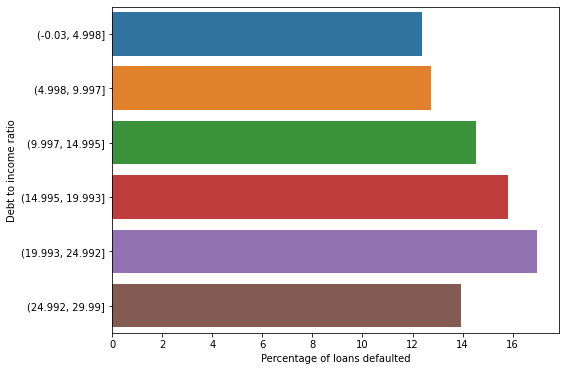

In [479]:
plot_data = loan_data.groupby('dti_bin')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(8,6))
sns.barplot(y='dti_bin', x='loan_status', data=plot_data)
plt.ylabel('Debt to income ratio')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Default rate is roughtly independent of "debt to income ratio"

---
### Check the distribution of loan status against **annual income**

<AxesSubplot:xlabel='annual_inc_bin'>

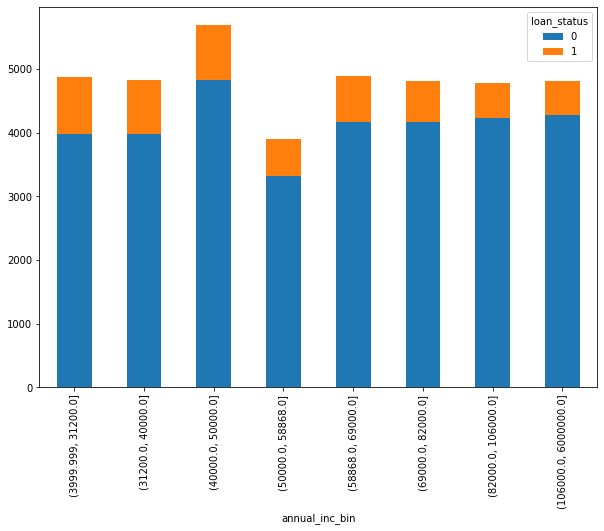

In [421]:
loan_data.groupby('annual_inc_bin')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10,7))

In [422]:
pd.pivot_table(loan_data, index=['annual_inc_bin'],values=['loan_status'])

,loan_status
annual_inc_bin,
"(3999.999, 31200.0]",0.184896
"(31200.0, 40000.0]",0.176166
"(40000.0, 50000.0]",0.151467
"(50000.0, 58868.0]",0.148718
"(58868.0, 69000.0]",0.148549
"(69000.0, 82000.0]",0.131918
"(82000.0, 106000.0]",0.113298
"(106000.0, 6000000.0]",0.110534


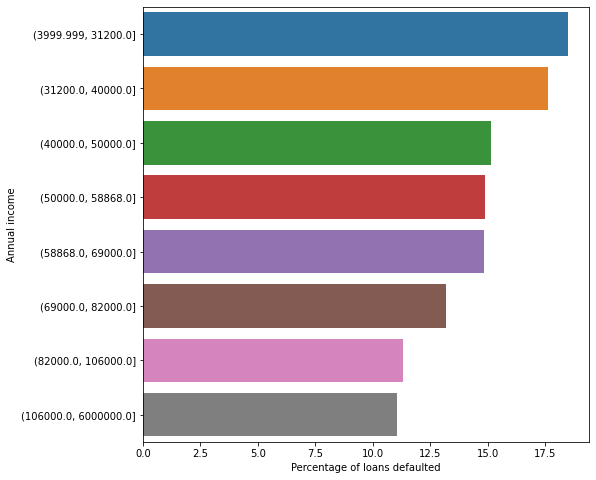

In [480]:
plot_data = loan_data.groupby('annual_inc_bin')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(8,8))
sns.barplot(y='annual_inc_bin', x='loan_status', data=plot_data)
plt.ylabel('Annual income')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Default rate slightly decreases with increase in annual income

---
### Check the distribution of loan status against **home ownership**

<AxesSubplot:xlabel='home_ownership'>

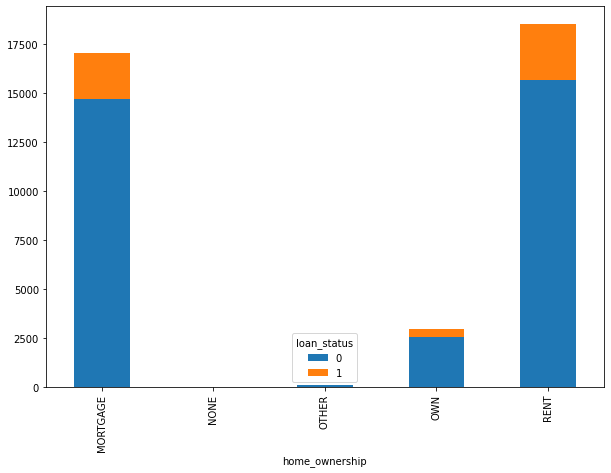

In [424]:
loan_data.groupby('home_ownership')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10,7))

In [425]:
pd.pivot_table(loan_data, index=['home_ownership'],values=['loan_status'])

,loan_status
home_ownership,
MORTGAGE,0.136713
NONE,0.000000
OTHER,0.183673
OWN,0.148908
RENT,0.153626


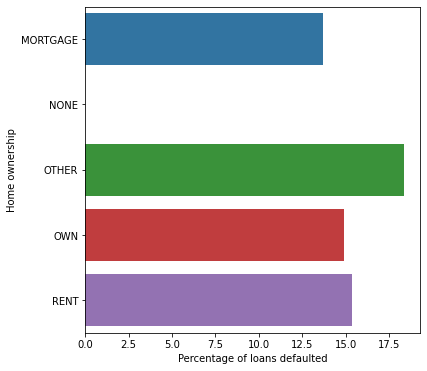

In [481]:
plot_data = loan_data.groupby('home_ownership')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(6,6))
sns.barplot(y='home_ownership', x='loan_status', data=plot_data)
plt.ylabel('Home ownership')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Default rate is roughtly independent of home ownership

---
### Check the distribution of loan status against **verification status**

<AxesSubplot:xlabel='verification_status'>

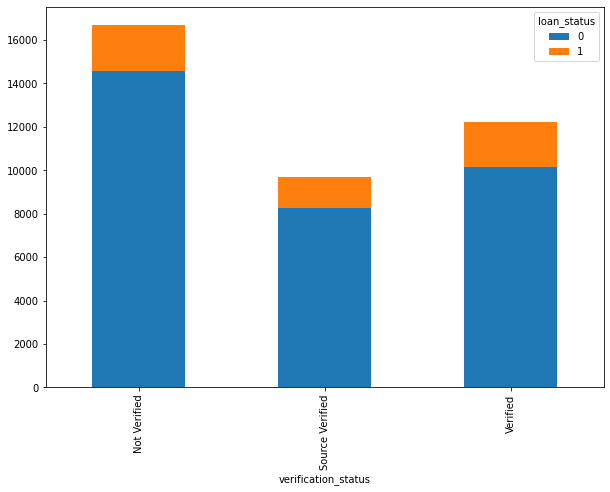

In [427]:
loan_data.groupby('verification_status')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(10,7))

> #### _We can merge source verified and verified as it implies that_

In [ ]:
loan_data['verification_status'] = loan_data.verification_status.replace({"Source Verified": "Verified"})

In [439]:
pd.pivot_table(loan_data, index=['verification_status'],values=['loan_status'])

,loan_status
verification_status,
Not Verified,0.128310
Verified,0.159256


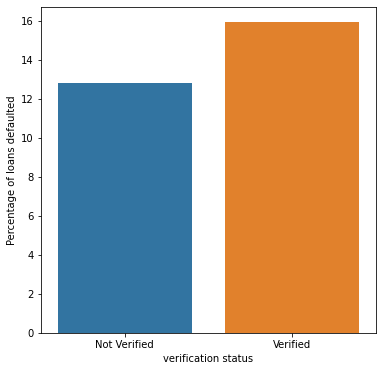

In [482]:
plot_data = loan_data.groupby('verification_status')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(6,6))
sns.barplot(x='verification_status', y='loan_status', data=plot_data)
plt.xlabel('verification status')
plt.ylabel('Percentage of loans defaulted')
plt.show()

> ## Verification status doesnt seem to have a noticable impact on default rate

---
### Check the distribution of loan status against **issue month**

<AxesSubplot:xlabel='issue_month'>

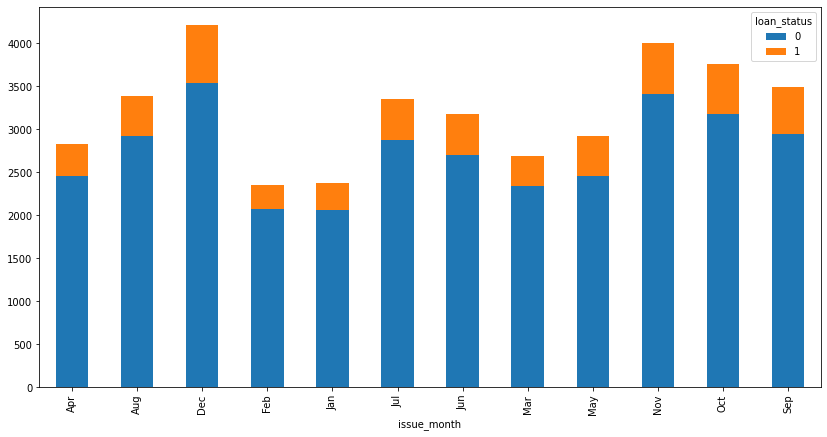

In [430]:
loan_data.groupby('issue_month')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(14,7))

In [431]:
pd.pivot_table(loan_data, index=['issue_month'],values=['loan_status'])

,loan_status
issue_month,
Apr,0.130696
Aug,0.138135
Dec,0.160854
Feb,0.122986
Jan,0.134931
Jul,0.142942
Jun,0.151887
Mar,0.128948
May,0.159644


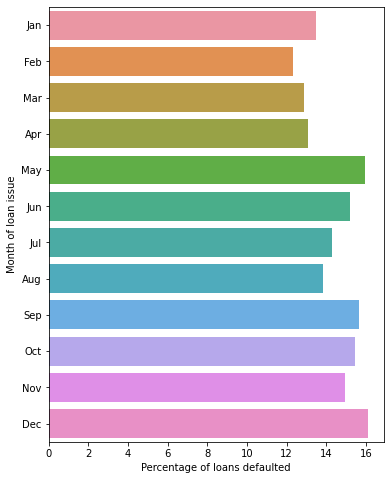

In [530]:
plot_data = loan_data.groupby('issue_month')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(6,8))
sns.barplot(y='issue_month', x='loan_status', data=plot_data, order=['Jan', 'Feb', 'Mar',
                                                                     'Apr', 'May', 'Jun',
                                                                     'Jul', 'Aug', 'Sep',
                                                                     'Oct', 'Nov', 'Dec'])
plt.ylabel('Month of loan issue')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Loans issued in December and May are more likely to default

---
### Check the distribution of loan status against **state**

<AxesSubplot:xlabel='addr_state'>

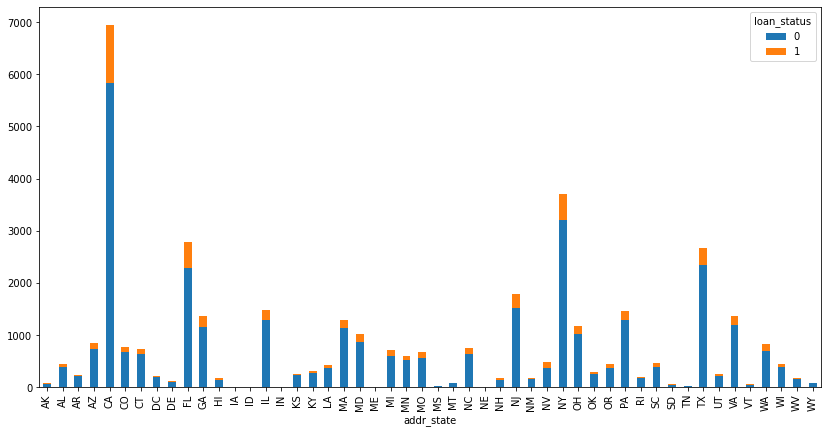

In [495]:
loan_data.groupby('addr_state')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(14,7))

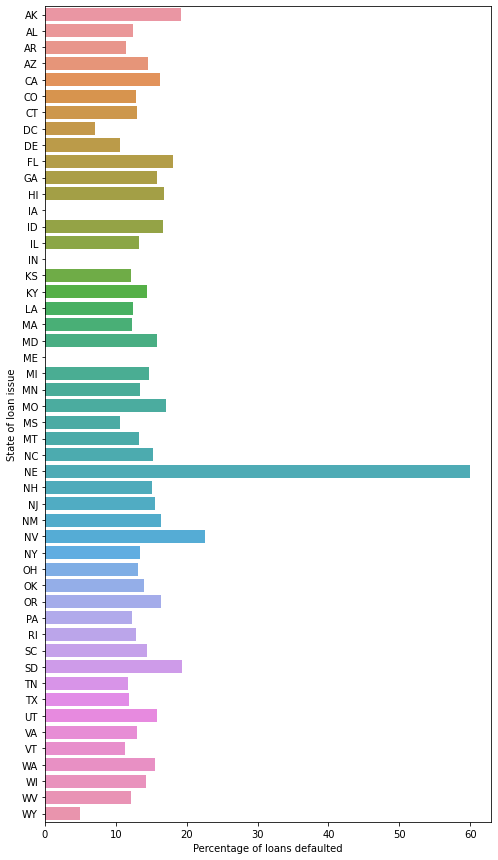

In [488]:
plot_data = loan_data.groupby('addr_state')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(8,15))
sns.barplot(y='addr_state', x='loan_status', data=plot_data)
plt.ylabel('State of loan issue')
plt.xlabel('Percentage of loans defaulted')
plt.show()

In [501]:
# check total number of loans issued in Nebraska
loan_data.loc[loan_data['addr_state'] == 'NE']

,loan_amnt,loan_status,purpose,term,int_rate,grade,sub_grade,emp_length,dti,annual_inc,home_ownership,verification_status,addr_state,zip_code,issue_month,dti_bin,annual_inc_bin,loan_amnt_bin,int_rate_bin
38685,7500,0,debt_consolidation,36 months,12.61,D,D1,10+ years,20.58,75000.0,MORTGAGE,Not Verified,NE,681xx,May,"(19.993, 24.992]","(69000.0, 82000.0]","(6250.0, 12000.0]","(11.747, 14.91]"
39500,14400,1,debt_consolidation,36 months,12.80,D,D4,1 year,8.47,36120.0,RENT,Not Verified,NE,689xx,Dec,"(4.998, 9.997]","(31200.0, 40000.0]","(12000.0, 17750.0]","(11.747, 14.91]"
39651,4800,0,debt_consolidation,36 months,11.22,C,C4,5 years,12.36,30000.0,RENT,Not Verified,NE,685xx,Sep,"(9.997, 14.995]","(3999.999, 31200.0]","(465.5, 6250.0]","(8.583, 11.747]"
39667,2500,1,home_improvement,36 months,12.80,D,D4,< 1 year,20.00,32000.0,MORTGAGE,Not Verified,NE,685xx,Aug,"(19.993, 24.992]","(31200.0, 40000.0]","(465.5, 6250.0]","(11.747, 14.91]"
39668,2500,1,home_improvement,36 months,9.64,B,B4,< 1 year,20.00,75000.0,MORTGAGE,Not Verified,NE,685xx,Aug,"(19.993, 24.992]","(69000.0, 82000.0]","(465.5, 6250.0]","(8.583, 11.747]"


> ## Although **Nebraska** have high percentage of loan failure but as the data contains only 5 records for this state, data is not enough to draw any conclusions

---
### Check the distribution of loan status against **zip code**

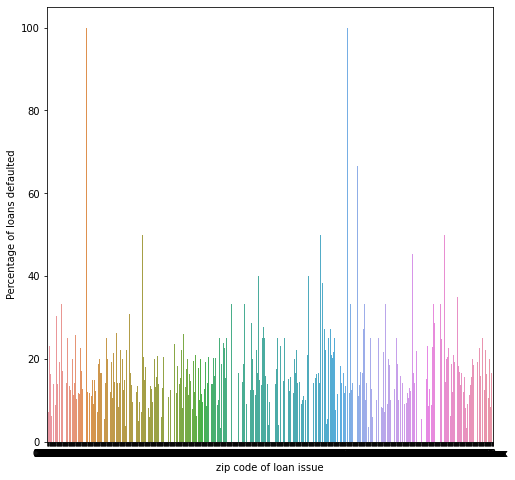

In [502]:
plot_data = loan_data.groupby('zip_code')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plt.figure(figsize=(8,8))
sns.barplot(x='zip_code', y='loan_status', data=plot_data)
plt.xlabel('zip code of loan issue')
plt.ylabel('Percentage of loans defaulted')
plt.show()

> ### Some zipcodes have spikes so lets find zipcodes with default rate higher than 50%

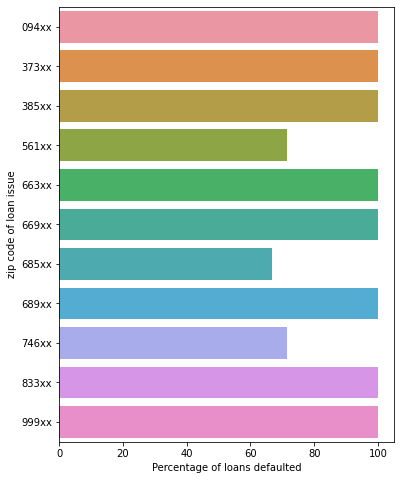

In [504]:
plot_data = loan_data.groupby('zip_code')['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plot_data = plot_data[plot_data.loan_status > 50]
plt.figure(figsize=(6,8))
sns.barplot(y='zip_code', x='loan_status', data=plot_data)
plt.ylabel('zip code of loan issue')
plt.xlabel('Percentage of loans defaulted')
plt.show()

In [505]:
loan_data.loc[loan_data['zip_code'] == '999xx']

,loan_amnt,loan_status,purpose,term,int_rate,grade,sub_grade,emp_length,dti,annual_inc,home_ownership,verification_status,addr_state,zip_code,issue_month,dti_bin,annual_inc_bin,loan_amnt_bin,int_rate_bin
7974,7650,1,credit_card,36 months,19.29,E,E4,4 years,12.28,39000.0,RENT,Not Verified,AK,999xx,Sep,"(9.997, 14.995]","(31200.0, 40000.0]","(6250.0, 12000.0]","(18.073, 21.237]"


In [507]:
loan_data.loc[loan_data['zip_code'] == '094xx']

,loan_amnt,loan_status,purpose,term,int_rate,grade,sub_grade,emp_length,dti,annual_inc,home_ownership,verification_status,addr_state,zip_code,issue_month,dti_bin,annual_inc_bin,loan_amnt_bin,int_rate_bin
3877,15600,1,home_improvement,36 months,19.42,E,E3,10+ years,6.42,148112.0,MORTGAGE,Verified,NY,094xx,Nov,"(4.998, 9.997]","(106000.0, 6000000.0]","(12000.0, 17750.0]","(18.073, 21.237]"
34744,19200,1,credit_card,36 months,12.87,C,C1,9 years,10.93,80000.0,RENT,Not Verified,NY,094xx,Oct,"(9.997, 14.995]","(69000.0, 82000.0]","(17750.0, 23500.0]","(11.747, 14.91]"


In [508]:
loan_data.loc[loan_data['zip_code'] == '373xx']

,loan_amnt,loan_status,purpose,term,int_rate,grade,sub_grade,emp_length,dti,annual_inc,home_ownership,verification_status,addr_state,zip_code,issue_month,dti_bin,annual_inc_bin,loan_amnt_bin,int_rate_bin
38811,20000,1,credit_card,36 months,12.29,C,C5,5 years,5.36,96000.0,MORTGAGE,Verified,TN,373xx,Apr,"(4.998, 9.997]","(82000.0, 106000.0]","(17750.0, 23500.0]","(11.747, 14.91]"


> ## We will again not draw any conclusion on this because as records per zipcode are too low

---
## Bivariate analysis

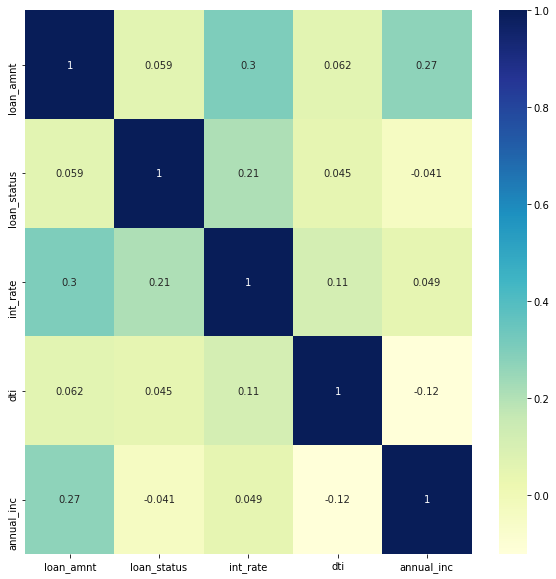

In [511]:
##BIVARIATE PLOTS
plt.figure(figsize=(10,10))
sns.heatmap(loan_data.corr(), cmap='YlGnBu', annot=True)
plt.show()

> ### As most of the columns are categorical, we dont have much to infer from this heatmap, specially related to loan_status, apart from the fact that interest rate and loan status are correlated, which we have already inferred

---
### Check the distribution of loan status against **dti and annual income**

<AxesSubplot:xlabel='dti_bin,annual_inc_bin'>

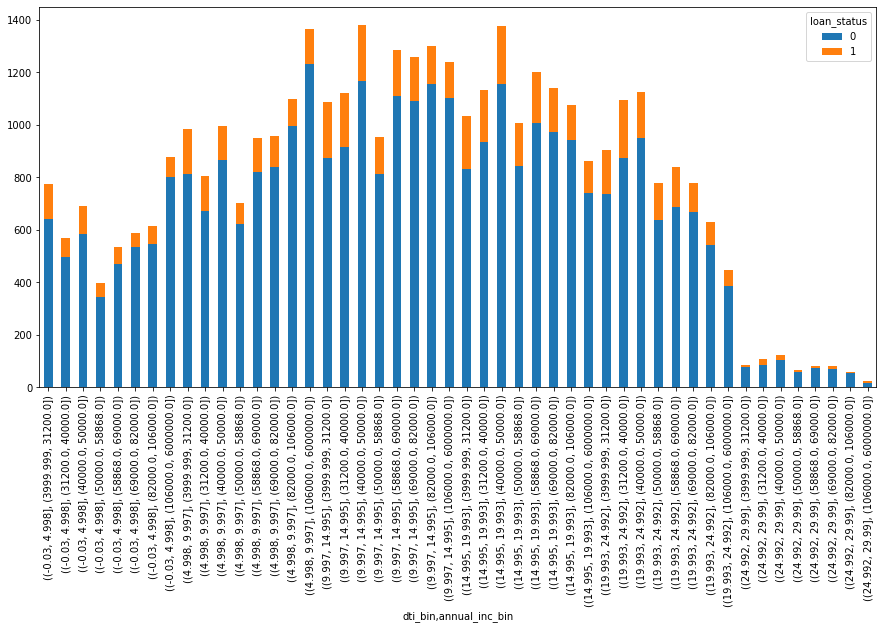

In [514]:
loan_data.groupby(['dti_bin', 'annual_inc_bin'])['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(15,7))

In [515]:
pd.pivot_table(loan_data, index=['dti_bin', 'annual_inc_bin'],values=['loan_status'])

loan_status
dti_bin          annual_inc_bin                    
(-0.03, 4.998]   (3999.999, 31200.0]       0.171613
                 (31200.0, 40000.0]        0.125220
                 (40000.0, 50000.0]        0.153846
                 (50000.0, 58868.0]        0.128788
                 (58868.0, 69000.0]        0.123364
                 (69000.0, 82000.0]        0.091681
                 (82000.0, 106000.0]       0.109121
                 (106000.0, 6000000.0]     0.087600
(4.998, 9.997]   (3999.999, 31200.0]       0.175635
                 (31200.0, 40000.0]        0.162935
                 (40000.0, 50000.0]        0.130391
                 (50000.0, 58868.0]        0.113960
                 (58868.0, 69000.0]        0.138801
                 (69000.0, 82000.0]        0.124088
                 (82000.0, 106000.0]       0.094718
                 (106000.0, 6000000.0]     0.096703
(9.997, 14.995]  (3999.999, 31200.0]       0.195772
                 (31200.0, 40000.0]        0.183929
                 (40000.0, 50000.0]        0.153512
                 (50000.0, 58868.0]        0.148109
                 (58868.0, 69000.0]        0.138306
                 (69000.0, 82000.0]        0.134340
                 (82000.0, 106000.0]       0.110085
                 (106000.0, 6000000.0]     0.110573
(14.995, 19.993] (3999.999, 31200.0]       0.195358
                 (31200.0, 40000.0]        0.175640
                 (40000.0, 50000.0]        0.158545
                 (50000.0, 58868.0]        0.160040
                 (58868.0, 69000.0]        0.161398
                 (69000.0, 82000.0]        0.147498
                 (82000.0, 106000.0]       0.121974
                 (106000.0, 6000000.0]     0.140534
(19.993, 24.992] (3999.999, 31200.0]       0.187845
                 (31200.0, 40000.0]        0.201281
                 (40000.0, 50000.0]        0.156306
                 (50000.0, 58868.0]        0.179718
                 (58868.0, 69000.0]        0.178998
                 (69000.0, 82000.0]        0.146154
                 (82000.0, 106000.0]       0.142631
                 (106000.0, 6000000.0]     0.136465
(24.992, 29.99]  (3999.999, 31200.0]       0.116279
                 (31200.0, 40000.0]        0.212963
                 (40000.0, 50000.0]        0.162602
                 (50000.0, 58868.0]        0.107692
                 (58868.0, 69000.0]        0.086420
                 (69000.0, 82000.0]        0.123457
                 (82000.0, 106000.0]       0.101695
                 (106000.0, 6000000.0]     0.181818

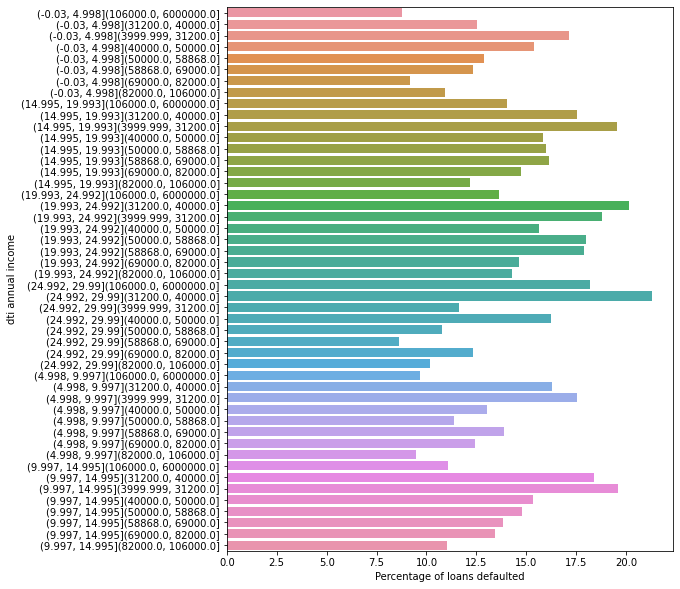

In [528]:
plot_data = loan_data.groupby(['dti_bin', 'annual_inc_bin'])['loan_status'].mean().reset_index()
plot_data['loan_status'] = plot_data['loan_status']*100
plot_data['dti_annual_inc'] = plot_data['dti_bin'].astype('str') + plot_data['annual_inc_bin'].astype('str')
plot_data['dti_annual_inc'] = plot_data['dti_annual_inc'].astype('category')
plt.figure(figsize=(8,10))
sns.barplot(y='dti_annual_inc', x='loan_status', data=plot_data)
plt.ylabel('dti annual income')
plt.xlabel('Percentage of loans defaulted')
plt.show()

> ## Nothing noticable